# Basic notebook info

ENG: This notebook is used for FER-model loading and fine-tuning. I used pre-trained VGGFace on ResNET-50, with one hidden layer on 512 neurons and final dense layer with 9 outputs. Only 13 last layers in VGGFace are trainable. In train and validation datasets I added augmentation with brightness, shear, zoom and flip modification.

RU: Данный ноутбук использов для загрузки и дообучения модели распознавания лицевых эмоций. Я использоловал предобученную сеть VGGFace на базе ResNET-50, добавив к ней один скрытый слой на 512 нейронов, и один выходной слой на 9 нейронов (по количеству типов эмоций в датасете). В исходной сети только последние 13 слоев разморожены. В обучающем и валидационном датасете я использовал аугментацию по яркости, деформации, масштабу и отражению.

# Dependenices installation

In [1]:
!pip install keras_vggface
!pip install livelossplot
!pip install keras_applications --no-deps


# Library import

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import model_from_json

from tensorflow import keras
from PIL import Image
from livelossplot.tf_keras import PlotLossesCallback
from keras_vggface.vggface import VGGFace

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
# from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_vggface.utils import preprocess_input as preprocess_input_vggface

%matplotlib inline


# Image generators with augmentation

In [22]:
# Important variables
BATCH_SIZE = 16
IMAGE_SIZE = 224
N_CLASSES = 9

# path to folder with folders of emotions
dataset_path = './_datasets/train_dataset/'

# initialize ImageDataGenerator with augmentation
data_gen = ImageDataGenerator(featurewise_center=False,
                              brightness_range=[0.6, 1],
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode="nearest",
                              horizontal_flip=True,
                              vertical_flip=True,
                              preprocessing_function=preprocess_input_vggface,
                              validation_split=0.2)

# train and validation generator
train_data_gen = data_gen.flow_from_directory(dataset_path,
                                              target_size=(
                                                  IMAGE_SIZE, IMAGE_SIZE),
                                              class_mode="sparse",
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              subset="training")

val_data_gen = data_gen.flow_from_directory(dataset_path,
                                            target_size=(
                                                IMAGE_SIZE, IMAGE_SIZE),
                                            class_mode="sparse",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            subset="validation")


Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


# Loading of VGGFace and fine-tuning

In [3]:
# Load VGGFace model with RESNet
vggface_model = VGGFace(model='resnet50', include_top=False,
                        input_shape=(224, 224, 3))
vggface_model.summary()


Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [4]:
# freeze of all netword excepting last N
last_N = 13
vggface_model.trainable = True
for layer in vggface_model.layers[:178-last_N]:
    layer.trainable = False
    
# build final model
model = tf.keras.Sequential([
    vggface_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9)])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 24,614,857
Trainable params: 4,466,697
Non-trainable params: 20,148,160
_________________________________________________________________


# Load of existing network

In [4]:
# uncomment code below to use existing model and weights

# with open("./_models/emotion_classification/model.json", 'r') as json_file:
#     loaded_model_json = json_file.read()
# model = model_from_json(loaded_model_json)
# model.load_weights("./_models/emotion_classification/saved_weights")

# Final model compile

In [6]:
# compiling model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy',
                              factor=0.6, patience=8, verbose=1, mode='max',
                              min_lr=5e-5)
checkpoint = ModelCheckpoint('./_models/vgg50_finetune',
                             monitor='val_sparse_categorical_accuracy',
                             mode='max', verbose=1, save_best_only=True)

learning_rate = 0.00005
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


# Model fitting

In [9]:
# train model
EPOCHS = 1
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[lr_reduce, checkpoint])

2503/2503 [==============================] - ETA: 0s - loss: 1.7155 - sparse_categorical_accuracy: 0.3786
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.43100, saving model to ./_models\vgg50_finetune
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./_models\vgg50_finetune\assets
2503/2503 [==============================] - 763s 305ms/step - loss: 1.7155 - sparse_categorical_accuracy: 0.3786 - val_loss: 1.5757 - val_sparse_categorical_accuracy: 0.4310


# Evaluate model

In [7]:
# evaluate model
model.evaluate(val_data_gen)

626/626 [==============================] - 153s 244ms/step - loss: 1.7057 - sparse_categorical_accuracy: 0.3888s - loss: 1.70


[1.7057418823242188, 0.3888278305530548]

# Predicted emotions demonstration

In [12]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) is picture after vgg_preprocessing. 
    It has negative values and matplotlib cannot show it correctly.
    Function returns unprocessed image.

    return: unprocessed image in np.uint8. 
    """
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)
    
    return image

In [18]:
def show_faces(images, real_race=None, real_emotion=None, predicted_emotion=None):
    """
    Function shows image from data generator with real and predicted labels
    
    """
    plt.figure(figsize=(10,10))
    labels = {"Emotion": [predicted_emotion, real_emotion]}
    emotion_mapping = dict(list(enumerate(('Anger', 'Contempt',
                    'Disgust', 'Fear',
                    'Happy', 'Neutral',
                    'Sad', 'Surprise', 'Uncertain'))))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            elif name == "Emotion":
                real_emotion = int(real[i])
                predicted_emotion = np.argmax(predicted[i])
                real_str += f"{emotion_mapping[real_emotion]}, "
                pred_str += f"{emotion_mapping[predicted_emotion]}, "
                if real_emotion != predicted_emotion:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

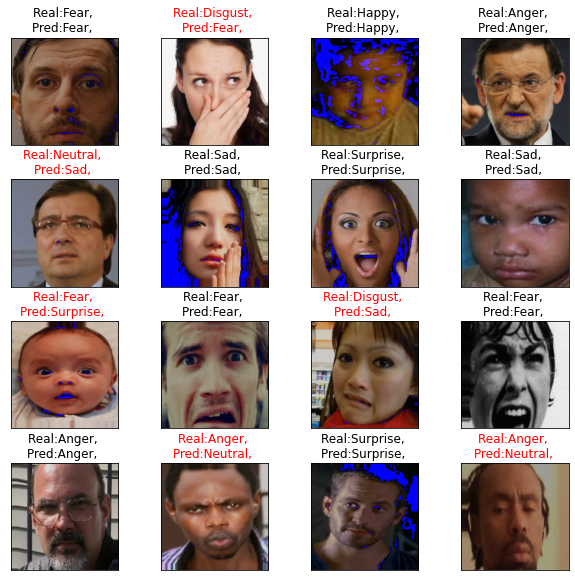

In [24]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, real_emotion=sample_validation_labels, predicted_emotion=predicted)

# Save model to json with separate weights

In [41]:
model_json = model.to_json()
with open("vgg_face_finetuned.json","w") as json_file:
    json_file.write(model_json)

In [42]:
model.save_weights('vgg_face_finetuned')